In [ ]:
!pip install darts
!pip install pyyaml==5.4.1
!pip install -q xlrd
!pip install matplotlib==3.1.1

  Using cached matplotlib-3.5.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.1
    Uninstalling matplotlib-3.1.1:
      Successfully uninstalled matplotlib-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


  Using cached matplotlib-3.1.1-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.0 requires matplotlib>=3.3, but you have matplotlib 3.1.1 which is incompatible.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.19.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.models import TransformerModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


pd.set_option("display.precision",7)
np.set_printoptions(precision=7, suppress=True)
pd.options.display.float_format = '{:,.7f}'.format

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE_LAT_LON = "/drive/MyDrive/TForm_LATLON_mode001e.pth.tar"

# IF DOESNT WORK TRY DIM_FF 64 OR ACTF RELU
EPOCHS = 10
INLEN = 8          # input size
FEAT = 16           # d_model = number of expected features in the inputs, up to 512    
HEADS = 4           # default 8
ENCODE = 4          # encoder layers
DECODE = 4          # decoder layers
DIM_FF = 128        # dimensions of the feedforward network, default 2048
BATCH = 8          # batch size
ACTF = "relu"       # activation function, relu (default) or gelu
SCHLEARN = None     # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1       # dropout rate
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9        # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath_lat_lon= os.path.abspath(os.getcwd()) + SAVE_LAT_LON    # path and file name to save the model

In [ ]:
ds = pd.read_excel("/content/drive/MyDrive/CSUEB/capstone/data/15.xlsx")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95394 entries, 0 to 95393
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         95394 non-null  float64
 1   iyear              95394 non-null  float64
 2   imonth             95394 non-null  float64
 3   iday               95394 non-null  float64
 4   date_num           95394 non-null  float64
 5   extended           95394 non-null  float64
 6   hdi2019            95394 non-null  float64
 7   unemployment_rate  95394 non-null  float64
 8   country            95394 non-null  float64
 9   region             95394 non-null  float64
 10  latitude           95394 non-null  float64
 11  longitude          95394 non-null  float64
 12  combined_lon_lat   95394 non-null  float64
 13  combined_lat_lon   95394 non-null  float64
 14  x                  95394 non-null  float64
 15  y                  95394 non-null  float64
 16  z                  953

In [ ]:
df = pd.DataFrame(ds)
df.index = pd.RangeIndex(start=0, stop=95394, step=1)

In [ ]:
# Feature corelated to latlon
ds_dn = df[["target1","date_num","city","latlon"]]

# create time series object for target variable
ts_DN = TimeSeries.from_series(ds_dn["latlon"]) 

# create time series object for the feature columns
df_covF_DN = ds_dn.loc[:, ds_dn.columns != "latlon"]
ts_covF_DN = TimeSeries.from_dataframe(df_covF_DN)


In [ ]:
ts_train_dn, ts_test_dn = ts_DN.split_after(SPLIT)

In [ ]:
# scaling of target variable
scalerDN = Scaler(MinMaxScaler(feature_range=(-1, 1)))
scalerDN.fit_transform(ts_train_dn)
ts_ttrain_dn = scalerDN.transform(ts_train_dn)
ts_ttest_dn = scalerDN.transform(ts_test_dn)    
ts_t_dn = scalerDN.transform(ts_DN)

# make sure data are of type float
ts_t_dn = ts_t_dn.astype(np.float64)
ts_ttrain_dn = ts_ttrain_dn.astype(np.float64)
ts_ttest_dn = ts_ttest_dn.astype(np.float64)

print("first and last row of scaled target time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t_dn.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target time series:


component,latlon
time,
0,0.5998
95393,0.5650


In [ ]:
# train/test split and scaling of feature covariates for date_num
covF_train_dn, covF_test_dn = ts_covF_DN.split_after(SPLIT)

scalerF_DN = Scaler(MinMaxScaler(feature_range=(-1, 1)))
scalerF_DN.fit_transform(covF_train_dn)
covF_ttrain_dn = scalerF_DN.transform(covF_train_dn) 
covF_ttest_dn = scalerF_DN.transform(covF_test_dn)   
covF_t_dn = scalerF_DN.transform(ts_covF_DN)  

# make sure data are of type float
covF_ttrain_dn = ts_ttrain_dn.astype(np.float32)
covF_ttest_dn = ts_ttest_dn.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t_dn.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,target1,date_num,city
time,,,
0,0.8914,-1.0000,-0.7461
95393,0.6642,1.1090,0.6772


In [ ]:
model = TransformerModel(
                    input_chunk_length = INLEN,
                    output_chunk_length = N_FC,
                    batch_size = BATCH,
                    n_epochs = EPOCHS,
                    model_name = "Transformer_lat_lon",
                    nr_epochs_val_period = VALWAIT,
                    d_model = FEAT,
                    nhead = HEADS,
                    num_encoder_layers = ENCODE,
                    num_decoder_layers = DECODE,
                    dim_feedforward = DIM_FF,
                    dropout = DROPOUT,
                    activation = ACTF,
                    random_state=RAND,
                    likelihood=QuantileRegression(quantiles=QUANTILES), 
                    optimizer_kwargs={'lr': LEARN},
                    add_encoders={"cyclic": {"future": ["date_num"]}},
                    save_checkpoints=True,
                    force_reset=True,
                    )

In [ ]:
# model for date_num
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath_lat_lon)
    model_DN = TransformerModel.load_model(mpath_lat_lon)                            # load previously model from disk 
else:
    model_DN = model
    model_DN.fit(  ts_ttrain_dn,verbose=True)
    print("have saved the model after training:", mpath_lat_lon)
    model_DN.save_model(mpath_lat_lon)

have loaded a previously saved model from disk:/content/drive/MyDrive/TForm_LATLON_mode0023e_testing.pth.tar


In [ ]:
# Prediction of date_num
ts_tpred_dn = model_DN.predict(   n=len(ts_ttest_dn), 
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)

Predicting: 0it [00:00, ?it/s]

In [ ]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
ts_q90 = None
ts_q99 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY[["latlon"]] = TimeSeries.pd_dataframe(ts_test_dn)

In [ ]:
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerDN.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "latlon" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test_dn)
        q50_MAPE = mape(ts_q50, ts_test_dn) 
        print("RMSE 50:", f'{q50_RMSE:.2f}')
        print("MAPE 50:", f'{q50_MAPE:.2f}')

In [ ]:
_DN = [predQ(ts_tpred_dn, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col_date_num = dfY.pop("latlon50")
dfY.insert(1, col_date_num.name, col_date_num)
dfY.iloc[np.r_[0:2, -2:0]]

dfY.to_excel('/content/drive/MyDrive/CSUEB/capstone/data/LatLontranform_001.xlsx')

0.01
RMSE: 1.3212
MAPE: 165.3380
0.1
RMSE: 0.5446
MAPE: 2540.2007
0.2
RMSE: 0.2936
MAPE: 223.4774
0.5
RMSE: 0.1888
MAPE: 23.3472
0.8
RMSE: 0.2496
MAPE: 29.4198
0.9
RMSE: 0.3056
MAPE: 36.2751
0.99
RMSE: 0.4065
MAPE: 45.1161


,latlon,latlon50,latlon01,latlon10,latlon20,latlon80,latlon90,latlon99
time,,,,,,,,
85854,"5,219,581.00","4,436,148.01","2,752,354.85","3,642,156.09","4,011,235.85","4,491,002.19","4,817,347.67","5,183,233.39"
85855,"4,550,295.00","4,438,946.75","2,655,534.55","3,830,846.06","4,088,782.98","4,484,016.33","4,565,038.62","5,176,310.37"
95392,"4,460,579.00","4,365,306.83","-43,500.74","2,317,083.47","3,440,025.69","4,728,699.14","4,856,909.84","5,287,592.58"
95393,"4,507,269.00","4,459,896.43","493,072.77","3,273,152.36","3,824,664.74","4,737,555.30","4,890,442.05","5,289,921.68"


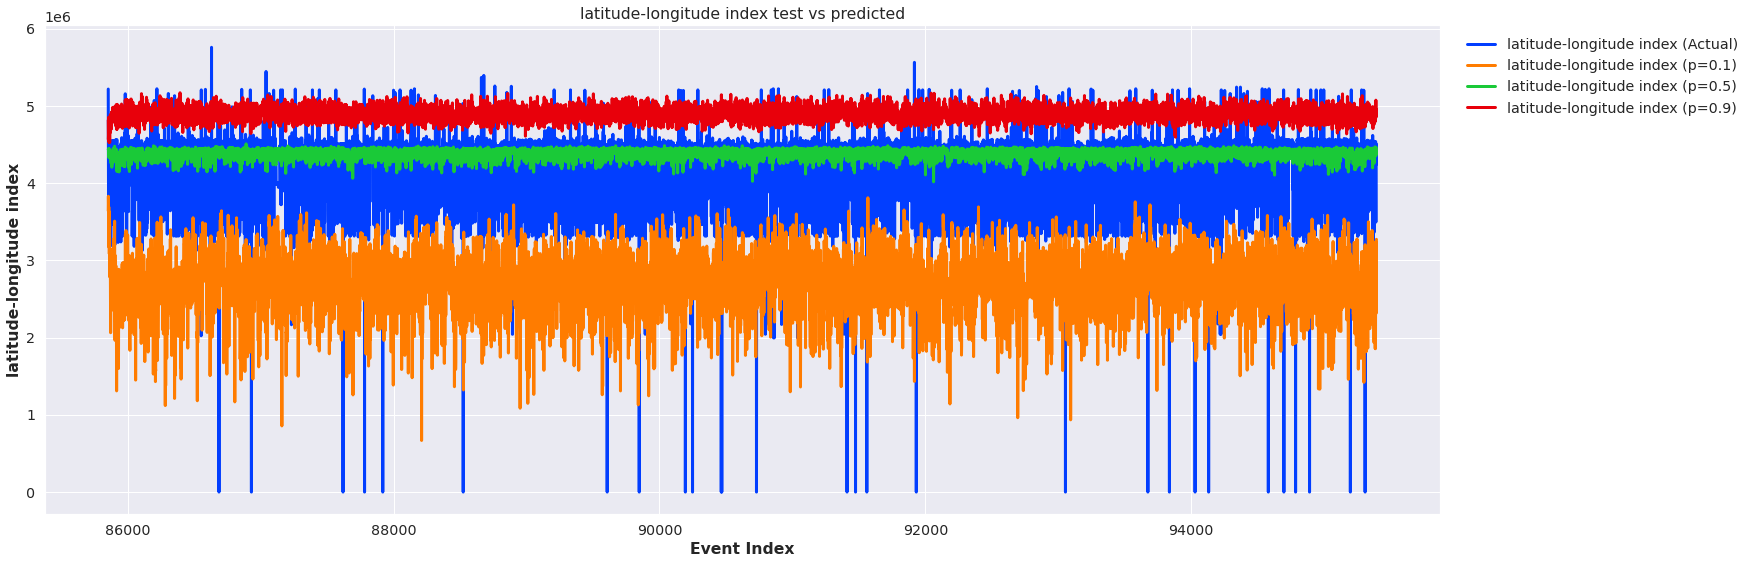

In [ ]:
# plot the forecast
plt.figure(100, figsize=(25, 9))
sns.set(font_scale=1.3)
sns.set_palette("bright")
D = dfY[0:150]
p = sns.lineplot(x = "time", y = "latlon", data = D, linewidth = 3 )
sns.lineplot(x = "time", y = "latlon50", data = D, linewidth = 3)
plt.legend(labels=["latitude-longitude index (Actual)",
                   "latitude-longitude index (p=0.5)",],
           bbox_to_anchor=(1.01, 1.0), loc='upper left')

p.set_ylabel("latitude-longitude index")
p.set_xlabel("Event Index")
p.set_title("latitude-longitude index test vs predicted");

In [ ]:
# choose forecast horizon: k hours beyond end of test set
k = 32   

n_FC = k + len(ts_ttest_dn)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC)

forecast beyond end of training set: 9572


In [ ]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model_DN.predict(   n=n_FC, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)

In [ ]:
_DN = [predQ(ts_tpred_dn, q) for q in QUANTILES]

print(dfY[["latlon","latlon50"]])
# move Q50 column to the left of the Actual column
col_date_num = dfY.pop("latlon50")
dfY.insert(1, col_date_num.name, col_date_num)
dfY.iloc[np.r_[0:2, -2:0]]

dfY.to_excel('/content/drive/MyDrive/CSUEB/capstone/data/LatLontranform_fut2.xlsx')

In [ ]:
# plot the forecast
plt.figure(100, figsize=(25, 9))
sns.set(font_scale=1.3)
sns.set_palette("bright")
D = dfY[0:150]
p = sns.lineplot(x = "time", y = "latlon", data = D, linewidth = 1 )
sns.lineplot(x = "time", y = "latlon50", data = D, linewidth = 1)
plt.legend(labels=[ 
                   "latitude-longitude index (Actual)",
                   "latitude-longitude index (p=0.5)",
                   ],
           bbox_to_anchor=(1.01, 1.0), loc='upper left')

p.set_ylabel("latitude-longitude index")
p.set_xlabel("Event Index")
p.set_title("latitude-longitude index test vs predicted");